In [1]:
directory = 'C:\\Users\\User\\OneDrive - Asia Pacific University\\FYP\\NewData'

In [2]:
import cv2
import os
import hashlib
from PIL import Image
def load_images_from_folder(folder):
    # Dictionary to hold image counts by folder
    image_counts = {}
    total_images = 0  # Initialize total image counter

    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith((".png", ".jpg", ".jpeg")):  # Check for image files
                sub_folder = os.path.basename(root)
                if sub_folder in image_counts:
                    image_counts[sub_folder] += 1
                else:
                    image_counts[sub_folder] = 1
                total_images += 1  # Increment total images count

    return image_counts, total_images

In [3]:
image_counts, total_images = load_images_from_folder(directory)

# Print the number of images for each folder
for folder, count in image_counts.items():
    print(f"{folder}: {count} images")
    
# Print the total number of images
print(f"Total images: {total_images} images")

0: 1315 images
1: 1266 images
2: 765 images
3: 742 images
4: 678 images
discarded: 157 images
normal: 1315 images
patient: 6474 images
Total images: 12712 images


Data Understanding (Before Preprocessing)

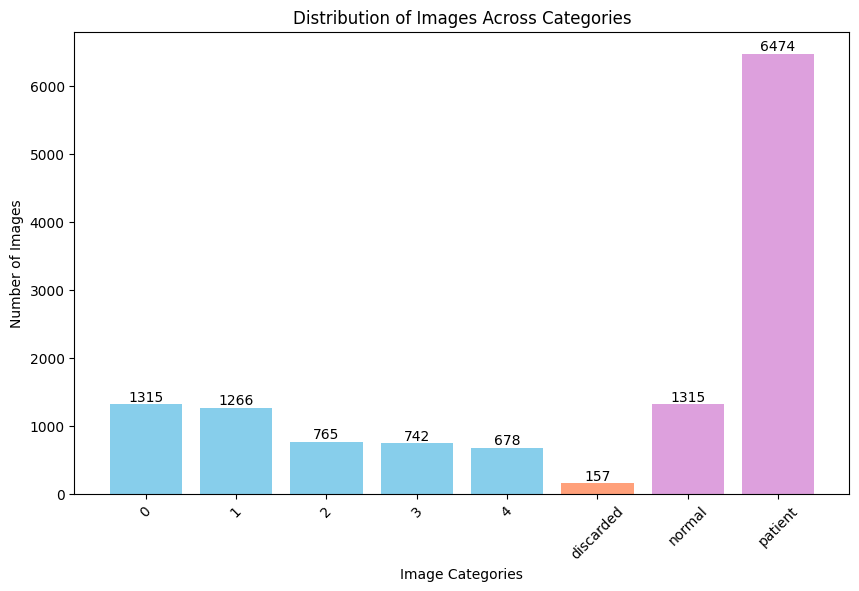

In [4]:
#show number of images for each category
import matplotlib.pyplot as plt

# Extract categories and their counts for plotting
categories = list(image_counts.keys())
counts = list(image_counts.values())

# Define colors based on category names
colors = []
for category in categories:
    if "discarded" in category:
        colors.append('lightsalmon')  # Color for discarded
    elif category.isdigit():
        colors.append('skyblue')  # Color for all KLGrade categories
    elif "normal" in category:
        colors.append('plum')  # Color for normal
    elif "patient" in category:
        colors.append('plum')  # Color for patient

# Plotting the results
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=colors)
plt.xlabel('Image Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Categories')
plt.xticks(rotation=45)

# Adding the text labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.show()

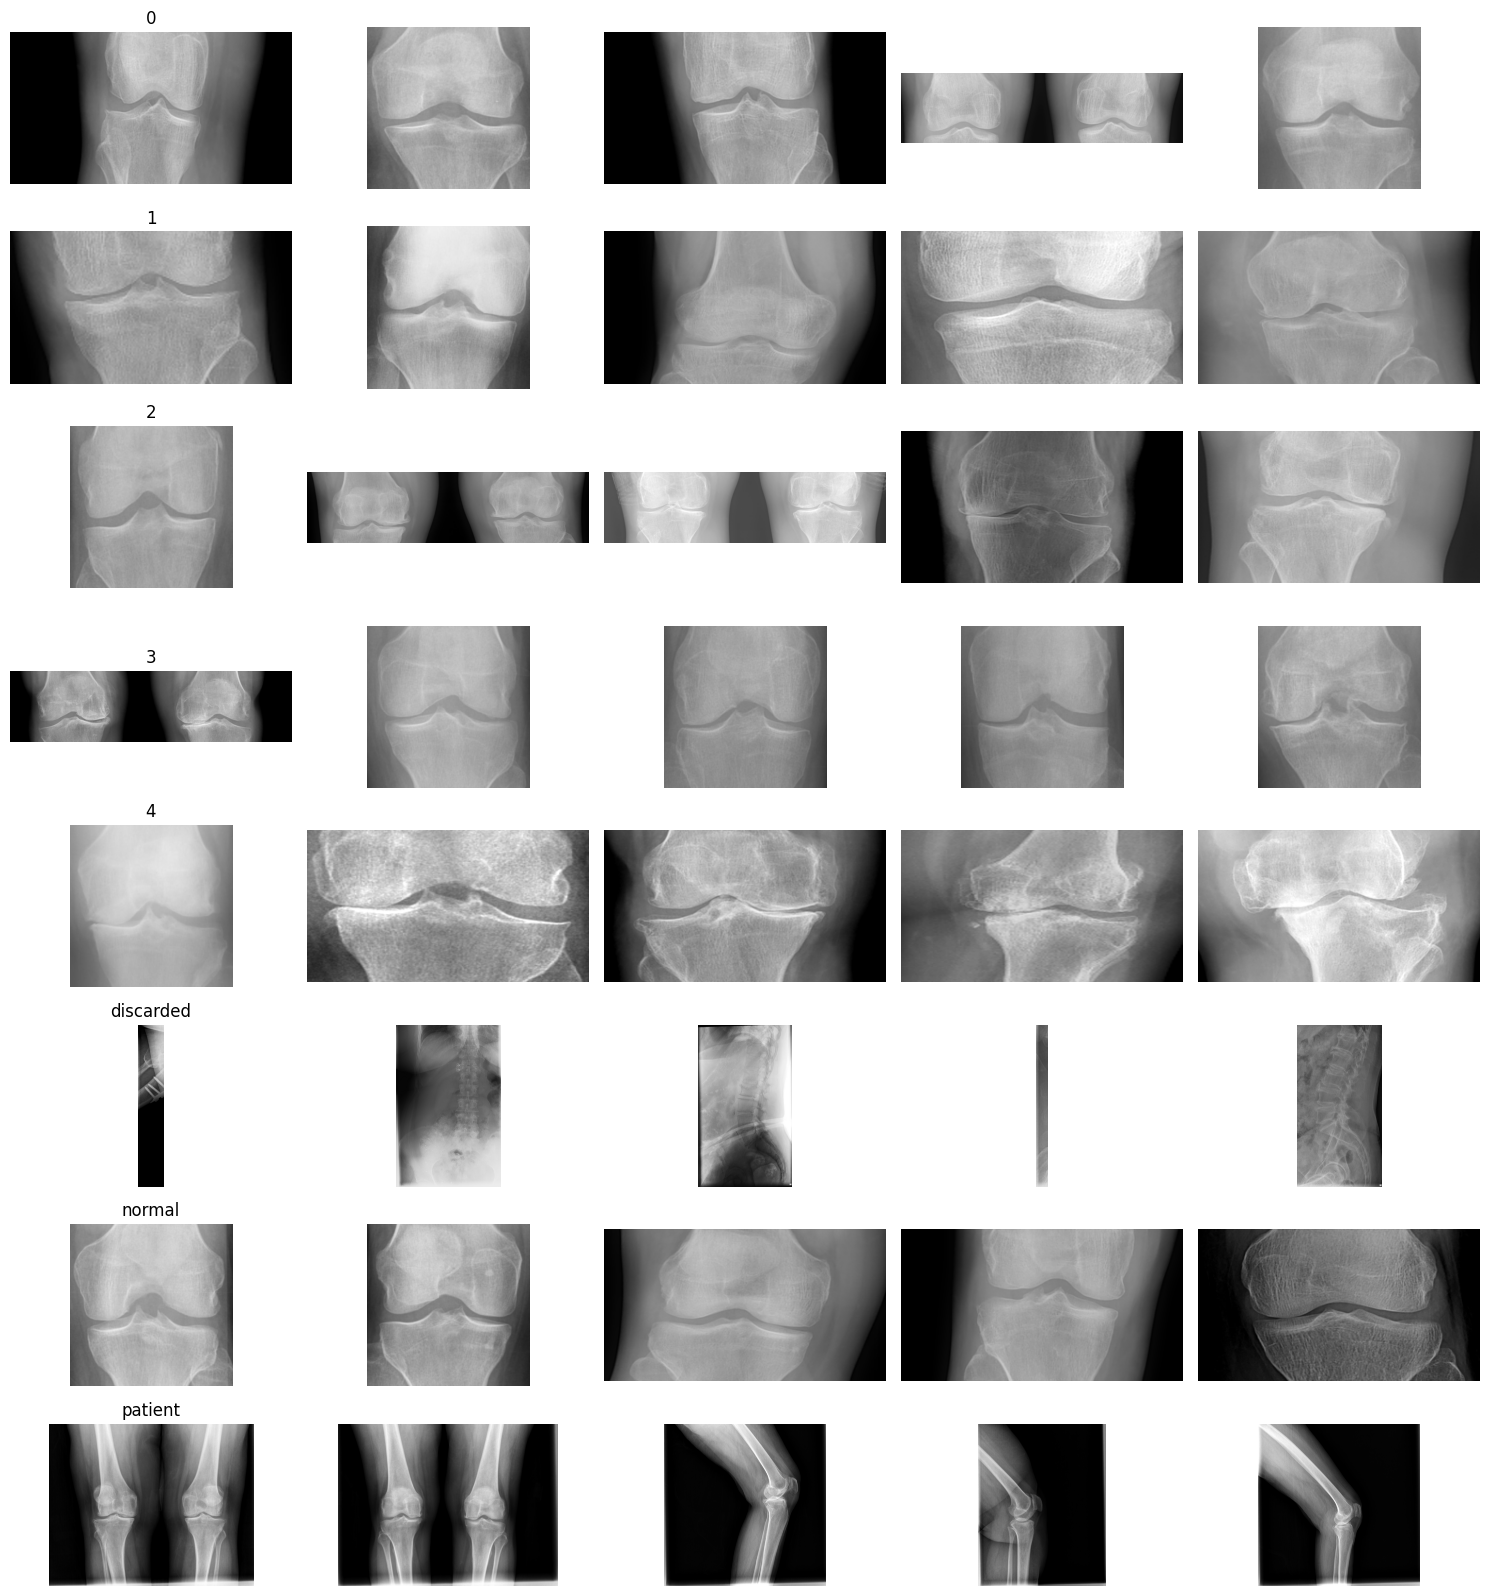

In [5]:
#display sample images for each category
import random

def display_sample_images(directory, samples_per_category=5):
    fig, axs = plt.subplots(len(os.listdir(directory)), samples_per_category, figsize=(15, 2 * len(os.listdir(directory))))
    for idx, category in enumerate(os.listdir(directory)):
        category_path = os.path.join(directory, category)
        images = [os.path.join(category_path, img) for img in os.listdir(category_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)  # Shuffle to display random images
        for j in range(min(samples_per_category, len(images))):
            img = cv2.cvtColor(cv2.imread(images[j]), cv2.COLOR_BGR2RGB)
            if len(os.listdir(directory)) == 1:
                axs[j].imshow(img)
                axs[j].axis('off')
                axs[j].set_title(category if j == 0 else "")
            else:
                axs[idx, j].imshow(img)
                axs[idx, j].axis('off')
                axs[idx, j].set_title(category if j == 0 else "")
    plt.tight_layout()
    plt.show()

display_sample_images(directory)

Blurry Image Detection

In [13]:
import cv2
import os

def is_blurry(image_path, threshold=100):
    try:
        # Load image in grayscale
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to load image at {image_path}")
            return None 
        # Calculate the Laplacian
        laplacian = cv2.Laplacian(image, cv2.CV_64F)
        # Calculate variance
        variance = laplacian.var()
        return variance < threshold  # Returns True if blurry, False otherwise
    except Exception as e:
        print(f"Error processing image at {image_path}: {e}")
        return None

# Testing the function on a specific directory and image type

blurry_images = []
for category in os.listdir(directory):
    category_path = os.path.join(directory, category)
    for filename in os.listdir(category_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(category_path, filename)
            if is_blurry(file_path):
                blurry_images.append(filename)

print("Total blurry images:", len(blurry_images))


Total blurry images: 3471


In [7]:
import pandas as pd
import numpy as np

def image_characteristics(file_path):
    characteristics = {
        "format": [],
        "mode": [],
        "size": [],
        "mean": [],
        "std": []
    }

    for folder in os.listdir(file_path):
        filename = os.path.join(file_path, folder)
        if os.path.isdir(filename):
            for image in os.listdir(filename):
                image_path = os.path.join(filename, image)
                with Image.open(image_path) as img:
                    image_arr = np.array(img)
                    characteristics["format"].append(img.format)
                    characteristics["mode"].append(img.mode)
                    characteristics["size"].append(img.size)
                    characteristics["mean"].append(np.mean(image_arr))
                    characteristics["std"].append(np.std(image_arr))
                    
    return characteristics

img_char = image_characteristics(directory)
char_df = pd.DataFrame(img_char)
char_df.head()

print(f"Image format: {char_df['format'].unique()}")
print(f"Mode: {char_df['mode'].unique()}")
print(f"Size: {char_df['size'].unique()}")

print("\n Mean pixel values: ")
print(char_df["mean"].describe())

print("\n Standard deviation pixel values: ")
print(char_df["std"].describe())

Image format: ['JPEG' 'PNG']
Mode: ['RGB' 'I;16']
Size: [(640, 640) (300, 162) (640, 161) ... (1585, 2619) (1800, 2447)
 (2643, 2677)]

 Mean pixel values: 
count    12712.000000
mean       574.319225
std       3466.005068
min         14.691710
25%         77.249289
50%         99.191626
75%        132.225679
max      33082.584550
Name: mean, dtype: float64

 Standard deviation pixel values: 
count    12712.000000
mean       373.405820
std       2305.347049
min          6.631422
25%         52.021946
50%         67.360700
75%         72.782076
max      20969.273791
Name: std, dtype: float64


Preprocessing

Remove general data

In [4]:
#remove unwanted files
import os
import shutil
import stat

def remove_read_only(func, path, _):
    """ Clear the readonly bit and reattempt the removal """
    os.chmod(path, stat.S_IWRITE)
    func(path)

folders_to_remove = ['discarded', 'normal', 'patient']

for folder in folders_to_remove:
    folder_path = os.path.join(directory, folder)
    if os.path.exists(folder_path):  # Ensure the folder exists before attempting to remove it
        try:
            shutil.rmtree(folder_path, onerror=remove_read_only)  # Delete the folder and all its contents
            print(f"Removed folder: {folder}")
        except Exception as e:
            print(f"Failed to remove {folder_path}: {e}")
    else:
        print(f"Folder not found: {folder}")

Removed folder: discarded
Removed folder: normal
Removed folder: patient


In [ ]:
from PIL import Image
def is_image_valid(file_path):
    """Check if the image can be opened and loaded."""
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify that it is, in fact, an image
        return True
    except (IOError, SyntaxError):
        return False
    

def remove_corrupted(folder):
    removed_corrupted = 0

    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)

            # Check for image file types
            if not file.endswith((".png", ".jpg", ".jpeg")):
                continue

            # Remove corrupted images
            if not is_image_valid(path):
                os.remove(path)
                removed_corrupted += 1
                continue
    print(f"Removed {removed_corrupted} corrupted files.")

remove_corrupted(directory)


Removed 0 corrupted files.


Resize

In [10]:
#resizing
def resize_image(image_path, output_size=(224, 224)):
    """Resize an image to the specified dimensions (width, height)."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        return None
    resized_image = cv2.resize(image, output_size, interpolation=cv2.INTER_AREA)
    return resized_image

def process_images(directory, output_size=(224, 224)):
    """Resize all images in the specified directory."""
    files_processed = False
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, filename) 
                files_processed = True
                
                resized_image = resize_image(file_path, output_size)
                if resized_image is not None:
                    cv2.imwrite(file_path, resized_image)  # Overwrite the original image
                    print(f"Resized and saved: {file_path}")
                else:
                    print("Error resizing image.")

    if not files_processed:
        print("No image files found or processed.")
        
process_images(directory)

Resized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_110_png.rf.640ac861f605968e142166b62b883aa2.jpg
Resized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_111_png.rf.feb50161b2231dc9244620846a45de3e.jpg
Resized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_112_png.rf.f0ab25148858fd1db3bdd5934037c7ae.jpg
Resized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_114_png.rf.c06380e33be324db4c96b3e0a072b47e.jpg
Resized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_115_png.rf.881d3bc5382da08dcd520cfc51304e69.jpg
Resized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_116_png.rf.e3c7074659111cbb1a6dbe43bb4ce70e.jpg
Resized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_11_png.rf.db3d03aee2056a5bf54619ae4ce5197e.jpg
Resized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewDa

Normalization

In [11]:
import cv2
import numpy as np
import os

def normalize_image(image_path):
    """Normalize an image to the range [0, 1]."""
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Failed to load image at {image_path}")
        return None
    normalized_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return normalized_image

#normalization
def process_images_for_normalization(directory):
    """Normalize all images in the specified directory."""
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, filename) 
                normalized_image = normalize_image(file_path)
                if normalized_image is not None:
                    cv2.imwrite(file_path, normalized_image*255)
                    print(f"Normalized and saved: {file_path}")


# Normalize all images in the directory
process_images_for_normalization(directory)


Normalized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_110_png.rf.640ac861f605968e142166b62b883aa2.jpg
Normalized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_111_png.rf.feb50161b2231dc9244620846a45de3e.jpg
Normalized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_112_png.rf.f0ab25148858fd1db3bdd5934037c7ae.jpg
Normalized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_114_png.rf.c06380e33be324db4c96b3e0a072b47e.jpg
Normalized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_115_png.rf.881d3bc5382da08dcd520cfc51304e69.jpg
Normalized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_116_png.rf.e3c7074659111cbb1a6dbe43bb4ce70e.jpg
Normalized and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_11_png.rf.db3d03aee2056a5bf54619ae4ce5197e.jpg
Normalized and saved: C:\Users\User\OneDrive - Asia Paci

Sharpening

In [14]:
def unsharp_mask(image, sigma=1.0, strength=1.5):
    """Apply Unsharp Mask to enhance edges in the image."""
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1 + strength, blurred, -strength, 0)
    return sharpened

blurry_images = []

for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, filename)
                if is_blurry(file_path):
                    blurry_images.append(file_path)

# Process and sharpen each blurry image
for image_path in blurry_images:
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    sharpened_image = unsharp_mask(image)
    cv2.imwrite(image_path, sharpened_image)
    print(f"Sharpened and saved: {image_path}")

Sharpened and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_110_png.rf.640ac861f605968e142166b62b883aa2.jpg
Sharpened and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_112_png.rf.f0ab25148858fd1db3bdd5934037c7ae.jpg
Sharpened and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_114_png.rf.c06380e33be324db4c96b3e0a072b47e.jpg
Sharpened and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_115_png.rf.881d3bc5382da08dcd520cfc51304e69.jpg
Sharpened and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_11_png.rf.db3d03aee2056a5bf54619ae4ce5197e.jpg
Sharpened and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_121_png.rf.ecee6abc58f8ecebf6218079e45bc8a7.jpg
Sharpened and saved: C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_122_png.rf.218033de632b23a1052f205a0bcc92f7.jpg
Sharpened and saved: C:\Users\User\OneDrive - Asia Pacific Univ

DATA AUGMENTATION

Rotation

In [15]:
import cv2
import numpy as np
import os
import random

def rotate_image(image, max_angle):
    """Rotate the image by a random angle within the specified range."""
    angle = random.uniform(-max_angle, max_angle)
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, matrix, (width, height))
    return rotated_image

Translation

In [16]:
def translate_image(image, max_translation):
    """Translate the image by random x and y pixels within the specified range."""
    x = random.randint(-max_translation, max_translation)
    y = random.randint(-max_translation, max_translation)
    translation_matrix = np.float32([[1, 0, x], [0, 1, y]])
    translated_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    return translated_image

Shearing

In [22]:
def shear_image(image, shear_range):
    """Shear the image by a random factor within the specified range."""
    rows, cols = image.shape[:2]
    x_shear = random.uniform(-shear_range, shear_range)
    y_shear = random.uniform(-shear_range, shear_range)
    shear_matrix = np.float32([[1, x_shear, 0], [y_shear, 1, 0]])
    sheared_image = cv2.warpAffine(image, shear_matrix, (cols, rows))
    return sheared_image

Augmentation

In [23]:
def augment_images(directory, max_angle=30, max_translation=40, shear_range=0.2):
    """Apply random rotation, translation, shearing, and cropping to all images in the specified directory."""
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, filename)
                image = cv2.imread(file_path)
                if image is None:
                    print(f"Failed to load image at {file_path}")
                    continue

                # Apply random rotation, translation, shearing, and cropping
                rotated_image = rotate_image(image, max_angle)
                translated_image = translate_image(image, max_translation)
                sheared_image = shear_image(image, shear_range)
                # cropped_image = crop_image(image, crop_size) if crop_size < min(image.shape[:2]) else image

                # Construct new file paths for augmented images
                base_filename, ext = os.path.splitext(filename)
                cv2.imwrite(os.path.join(root, f"{base_filename}_rotated{ext}"), rotated_image)
                cv2.imwrite(os.path.join(root, f"{base_filename}_translated{ext}"), translated_image)
                cv2.imwrite(os.path.join(root, f"{base_filename}_sheared{ext}"), sheared_image)
                # cv2.imwrite(os.path.join(root, f"{base_filename}_cropped{ext}"), cropped_image)

                print(f"Augmented images saved for {filename}")
                
augment_images(directory)
                

Augmented images saved for 0_110_png.rf.640ac861f605968e142166b62b883aa2.jpg
Augmented images saved for 0_111_png.rf.feb50161b2231dc9244620846a45de3e.jpg
Augmented images saved for 0_112_png.rf.f0ab25148858fd1db3bdd5934037c7ae.jpg
Augmented images saved for 0_114_png.rf.c06380e33be324db4c96b3e0a072b47e.jpg
Augmented images saved for 0_115_png.rf.881d3bc5382da08dcd520cfc51304e69.jpg
Augmented images saved for 0_116_png.rf.e3c7074659111cbb1a6dbe43bb4ce70e.jpg
Augmented images saved for 0_11_png.rf.db3d03aee2056a5bf54619ae4ce5197e.jpg
Augmented images saved for 0_120_png.rf.7f282c9f8f6a538b82581c8a83fa157c.jpg
Augmented images saved for 0_121_png.rf.ecee6abc58f8ecebf6218079e45bc8a7.jpg
Augmented images saved for 0_122_png.rf.218033de632b23a1052f205a0bcc92f7.jpg
Augmented images saved for 0_130_png.rf.c0c050fec07fe1e462041dc7e9cad339.jpg
Augmented images saved for 0_131_png.rf.e9d79d9655d06417d500788a1152be54.jpg
Augmented images saved for 0_132_png.rf.b9ac393fec0fd47dc23973e9b7e3c4d1.jpg


Code renaming convention

In [24]:
def rename_images_in_folder(directory):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path) and folder.isdigit():  # Ensure it's a folder named '0', '1', etc.
            images = sorted(os.listdir(folder_path))  # Sort for consistent renaming order
            for idx, image_name in enumerate(images):
                old_image_path = os.path.join(folder_path, image_name)
                new_image_name = f"{folder}_{idx + 1}.jpg"
                new_image_path = os.path.join(folder_path, new_image_name)

                os.rename(old_image_path, new_image_path)
                print(f"Renamed {old_image_path} → {new_image_path}")

rename_images_in_folder(directory)


Renamed C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_110_png.rf.640ac861f605968e142166b62b883aa2.jpg → C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_1.jpg
Renamed C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_110_png.rf.640ac861f605968e142166b62b883aa2_rotated.jpg → C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_2.jpg
Renamed C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_110_png.rf.640ac861f605968e142166b62b883aa2_sheared.jpg → C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_3.jpg
Renamed C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_110_png.rf.640ac861f605968e142166b62b883aa2_translated.jpg → C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_4.jpg
Renamed C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_111_png.rf.feb50161b2231dc9244620846a45de3e.jpg → C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData\0\0_5.jpg
Ren

0: 5260 images
1: 5064 images
2: 3060 images
3: 2968 images
4: 2712 images
Total images: 19064 images


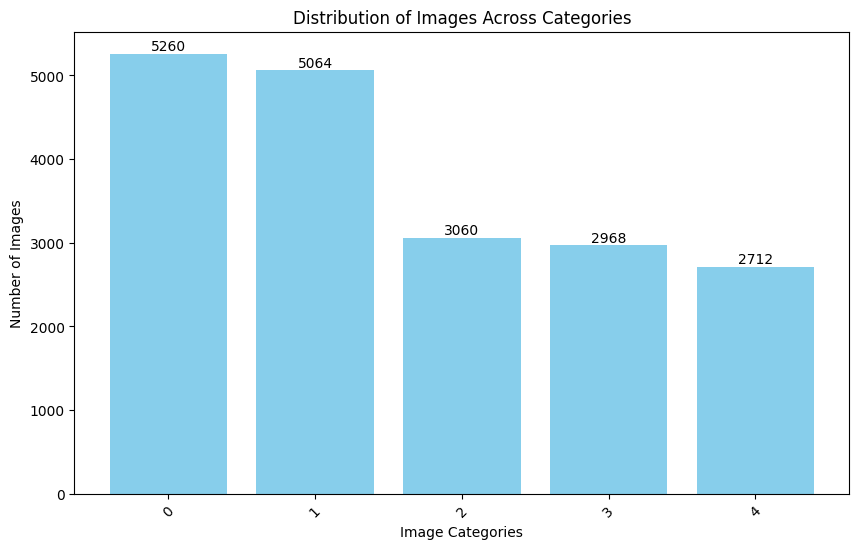

In [25]:
#show number of images for each category
import matplotlib.pyplot as plt

image_counts, total_images = load_images_from_folder(directory)

# Print the number of images for each folder
for folder, count in image_counts.items():
    print(f"{folder}: {count} images")
    
# Print the total number of images
print(f"Total images: {total_images} images")

# Extract categories and their counts for plotting
categories = list(image_counts.keys())
counts = list(image_counts.values())

# Define colors based on category names
colors = []
for category in categories:
    colors.append('skyblue')  # Color for all KLGrade categories

# Plotting the results
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=colors)  # Apply the specific colors to the bars
plt.xlabel('Image Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Categories')
plt.xticks(rotation=45)

# Adding the text labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.show()

In [26]:
import os
import numpy as np
import pandas as pd
from PIL import Image

def image_characteristics(root_dir):
    characteristics = {
        "format": [],
        "mode": [],
        "size": [],
        "mean": [],
        "std": []
    }

    # Walk all subdirectories under root_dir
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for fname in filenames:
            if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            path = os.path.join(dirpath, fname)
            try:
                with Image.open(path) as img:
                    arr = np.array(img)

                    characteristics["format"].append(img.format)
                    characteristics["mode"].append(img.mode)
                    characteristics["size"].append(img.size)
                    characteristics["mean"].append(float(arr.mean()))
                    characteristics["std"].append(float(arr.std()))
            except Exception as e:
                print(f"Skipping {path}: {e}")

    return pd.DataFrame(characteristics)


if __name__ == "__main__":
    data_dir = r'C:\Users\User\OneDrive - Asia Pacific University\FYP\NewData'

    df = image_characteristics(data_dir)

    print("First 5 rows:\n", df.head(), "\n")
    print("Unique formats:", df["format"].unique())
    print("Unique modes:  ", df["mode"].unique())
    print("Unique sizes:  ", df["size"].unique(), "\n")
    print("Mean pixel values summary:\n", df["mean"].describe(), "\n")
    print("Std pixel values summary:\n", df["std"].describe())


First 5 rows:
   format mode        size        mean        std
0   JPEG  RGB  (224, 224)  176.969567  56.443247
1   JPEG  RGB  (224, 224)  127.073282  67.953512
2   JPEG  RGB  (224, 224)  114.574597  83.707659
3   JPEG  RGB  (224, 224)  134.848334  68.652023
4   JPEG  RGB  (224, 224)  145.877551  54.105361 

Unique formats: ['JPEG' 'PNG']
Unique modes:   ['RGB']
Unique sizes:   [(224, 224)] 

Mean pixel values summary:
 count    19064.000000
mean       133.696493
std         22.914255
min         47.026766
25%        117.265132
50%        134.897810
75%        150.168029
max        208.097676
Name: mean, dtype: float64 

Std pixel values summary:
 count    19064.000000
mean        74.245775
std         12.705149
min         31.027952
25%         66.173814
50%         75.810268
75%         83.799382
max        105.475446
Name: std, dtype: float64


Split Data

In [27]:
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split

def setup_and_split_images(data_directory, val_size=0.1, test_size=0.1, stratify=True):
    data_directory = Path(data_directory)
    
    classes = [
        d.name for d in data_directory.iterdir()
        if d.is_dir() and d.name not in {'train','val','test'}
    ]
    if not classes:
        raise ValueError(f"No class subfolders found under {data_directory}")

    splits = ['train','val','test']
    for split in splits:
        for cls in classes:
            (data_directory/ split/ cls).mkdir(parents=True, exist_ok=True)

    all_items = []
    for cls in classes:
        cls_dir = data_directory/cls
        for img in cls_dir.iterdir():
            if img.suffix.lower() in {'.png','.jpg','.jpeg'}:
                all_items.append((str(img), cls))

    file_paths, file_labels = zip(*all_items)
    strat = file_labels if stratify else None

    train_files, rest_files, train_labels, rest_labels = train_test_split(
        file_paths, file_labels,
        test_size=(val_size + test_size),
        stratify=strat,
        random_state=42
    )

    strat_rest = rest_labels if stratify else None
    val_files, test_files, val_labels, test_labels = train_test_split(
        rest_files, rest_labels,
        test_size=test_size/(val_size + test_size),
        stratify=strat_rest,
        random_state=42
    )


    def move_into(split_files, split_labels, split_name):
        for src, cls in zip(split_files, split_labels):
            dst = data_directory/ split_name/ cls / Path(src).name
            shutil.move(src, dst)


    move_into(train_files, train_labels, 'train')
    move_into(val_files,   val_labels,   'val')
    move_into(test_files,  test_labels,  'test')

    print(f"Train: {len(train_files)} images")
    print(f"Validation: {len(val_files)} images")
    print(f"Test: {len(test_files)} images")

setup_and_split_images(directory)

Train: 15251 images
Validation: 1906 images
Test: 1907 images



Image counts for train:
  Class 0: 4208 images
  Class 1: 4051 images
  Class 2: 2448 images
  Class 3: 2374 images
  Class 4: 2170 images


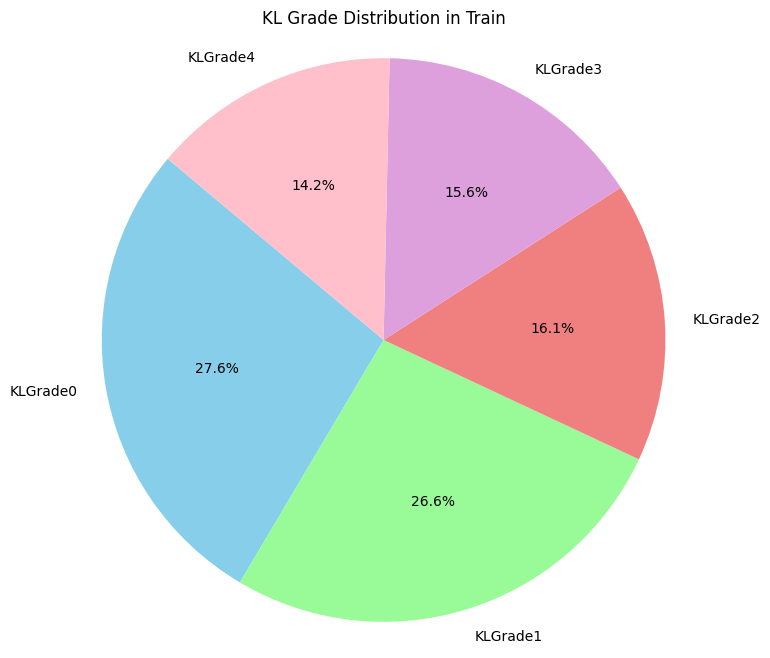


Image counts for val:
  Class 0: 526 images
  Class 1: 506 images
  Class 2: 306 images
  Class 3: 297 images
  Class 4: 271 images


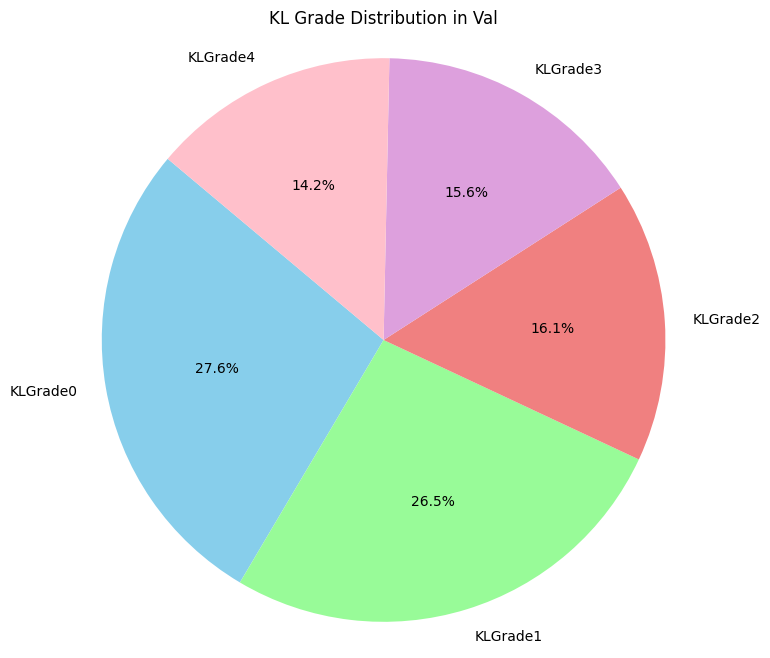


Image counts for test:
  Class 0: 526 images
  Class 1: 507 images
  Class 2: 306 images
  Class 3: 297 images
  Class 4: 271 images


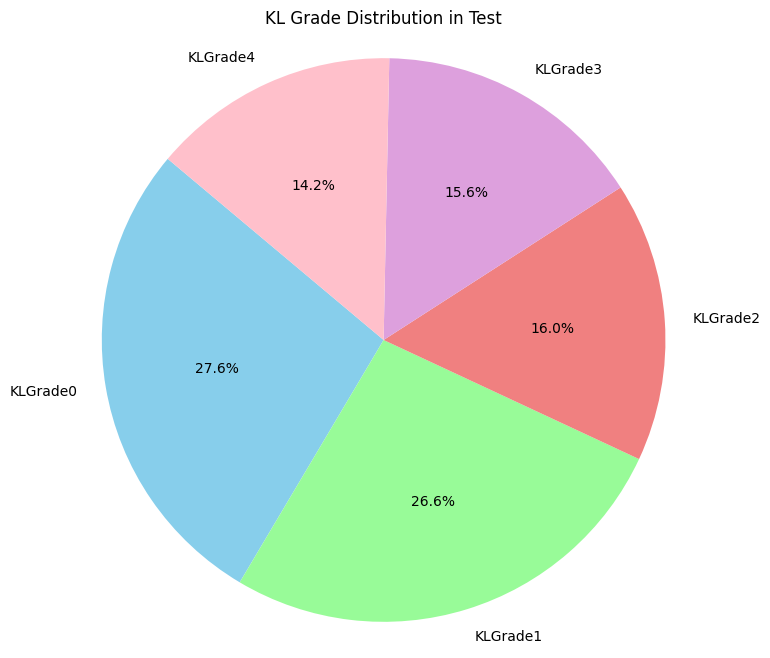

In [28]:
import os
import matplotlib.pyplot as plt


def count_images_by_prefix(split_dir):
    counts = {}
    # look into each class subfolder (0–4)
    for cls in os.listdir(split_dir):
        cls_path = os.path.join(split_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        for fname in os.listdir(cls_path):
            if not fname.lower().endswith(('.png','.jpg','.jpeg')):
                continue
            prefix = fname.split('_')[0]      # e.g. '0', '1', ...
            counts[prefix] = counts.get(prefix, 0) + 1
    return counts

def plot_pie_chart(counts, title, colors=None):
    # sort prefixes numerically for consistent order
    prefixes = sorted(counts.keys(), key=lambda p: int(p))
    labels   = [f"KLGrade{p}" for p in prefixes]
    sizes    = [counts[p] for p in prefixes]

    plt.figure(figsize=(8,8))
    if colors:
        plt.pie(sizes, labels=labels, autopct='%1.1f%%',
                startangle=140, colors=colors)
    else:
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# color map keyed by the numeric prefix
kl_grade_colors = {
    '0': 'skyblue',
    '1': 'palegreen',
    '2': 'lightcoral',
    '3': 'plum',
    '4': 'pink'
}

for split in ['train','val','test']:
    split_path = os.path.join(directory, split)
    if not os.path.isdir(split_path):
        print(f"Warning: {split_path} not found, skipping")
        continue

    counts = count_images_by_prefix(split_path)
    # map colors directly by prefix
    colors = [kl_grade_colors.get(p, 'gray') for p in sorted(counts, key=lambda p: int(p))]

    print(f"\nImage counts for {split}:")
    for p, cnt in sorted(counts.items(), key=lambda item: int(item[0])):
        print(f"  Class {p}: {cnt} images")

    plot_pie_chart(
        counts,
        title=f"KL Grade Distribution in {split.capitalize()}",
        colors=colors
    )


In [29]:
#remove unwanted folders
import os
import shutil
import stat

unwanted_folders = ['0', '1', '2', '3', '4']

for folder in unwanted_folders:
    folder_path = os.path.join(directory, folder)
    if os.path.exists(folder_path):
        try:
            shutil.rmtree(folder_path, onerror=remove_read_only)
            print(f"Removed folder: {folder}")
        except Exception as e:
            print(f"Failed to remove {folder_path}: {e}")
    else:
        print(f"Folder not found: {folder}")

Removed folder: 0
Removed folder: 1
Removed folder: 2
Removed folder: 3
Removed folder: 4
